In [25]:
#https://analyticsindiamag.com/name-language-prediction-using-recurrent-neural-network-in-pytorch/

In [36]:
from zipfile import ZipFile
file_name = "/content/Languages.zip"
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print("Done")



Done


In [45]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def printFiles(path):
  return glob.glob(path)

printFiles('/content/*.txt')

['/content/Scottish.txt',
 '/content/French.txt',
 '/content/Spanish.txt',
 '/content/Vietnamese.txt',
 '/content/Russian.txt',
 '/content/English.txt',
 '/content/Japanese.txt',
 '/content/Portuguese.txt',
 '/content/Italian.txt',
 '/content/Arabic.txt',
 '/content/Polish.txt',
 '/content/Chinese.txt',
 '/content/Irish.txt',
 '/content/Czech.txt',
 '/content/Korean.txt',
 '/content/German.txt',
 '/content/Dutch.txt',
 '/content/Greek.txt']

In [52]:
import unicodedata
import string

all_let = string.ascii_letters + " .,;'"
n_let = len(all_let)


def unicodeToAscii(s):
  return ''.join(
      c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn'
      and c in all_let
  )

In [54]:
cat_line = {}
all_cats = []

# Read a file and split into lines
def readLines(filename):
  lines = open(filename, encoding='utf-8').read().strip().split('\n')
  return [unicodeToAscii(line) for line in lines]

for filename in printFiles('/content/*.txt'):
  category = os.path.splitext(os.path.basename(filename))[0]
  all_cats.append(category)
  lines = readLines(filename)
  cat_line[category] = lines
  
n_categories = len(all_cats)



In [61]:
#Check names in a category
print(cat_line['Japanese'][:4])

['Abe', 'Abukara', 'Adachi', 'Aida']


In [62]:
import torch

# Find letter index from all_let, e.g. "a" = 0
def letterToIndex(letter):
  return all_let.find(letter)


# Turn a letter into a <1 x n_let> Tensor
def letterToTensor(letter):
  tensor = torch.zeros(1, n_let)
  tensor[0][letterToIndex(letter)] = 1
  return tensor


# Turn a line into a <line_length x 1 x n_let>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_let)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor


In [63]:
print(letterToTensor('K'))
print(lineToTensor('Kakinomoto').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([10, 1, 57])


In [64]:
import torch.nn as nn

class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(RNN, self).__init__()
    self.hidden_size = hidden_size
    self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
    self.i2o = nn.Linear(input_size + hidden_size, output_size)
    self.softmax = nn.LogSoftmax(dim=1)
  
  def forward(self, input, hidden):
    combined = torch.cat((input, hidden), 1)
    hidden = self.i2h(combined)
    output = self.i2o(combined)
    output = self.softmax(output)
    return output, hidden
  
  def initHidden(self):
    return torch.zeros(1, self.hidden_size)

n_hidden = 128
#Binding model
rnn = RNN(n_let, n_hidden, n_categories)
                      


In [65]:
input = lineToTensor('Aalsburg')
hidden = torch.zeros(1, n_hidden)
output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-3.0082, -2.9556, -2.8121, -2.8742, -2.9702, -2.9675, -2.8645, -2.8558,
         -2.9136, -2.8908, -2.8187, -2.8789, -2.7877, -2.8580, -2.9500, -2.9210,
         -2.8393, -2.8922]], grad_fn=<LogSoftmaxBackward>)


In [66]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_cats)
    line = randomChoice(cat_line[category])
    category_tensor = torch.tensor([all_cats.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

#Check on a random sample
for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Portuguese / line = Pereira
category = Vietnamese / line = Quach
category = Polish / line = Zawisza
category = Portuguese / line = Magalhaes
category = German / line = Hoch
category = German / line = Tobias
category = English / line = Gold
category = Irish / line = Mahoney
category = Czech / line = Riedel
category = French / line = Lachance


In [67]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_cats[category_i], category_i
#Check category for an output
print(categoryFromOutput(output))

('Irish', 12)


In [70]:
learning_rate = 0.005 

criterion = nn.NLLLoss()

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()


import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
      guess, guess_i = categoryFromOutput(output)
      correct = '✓' if guess == category else '✗ (%s)' % category
      print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
      all_losses.append(current_loss / plot_every)
      current_loss = 0


5000 5% (0m 6s) 2.6651 Kubo / Portuguese ✗ (Japanese)
10000 10% (0m 12s) 2.1036 Duarte / Portuguese ✓
15000 15% (0m 18s) 2.8463 Elizondo / Italian ✗ (Spanish)
20000 20% (0m 24s) 0.1243 Dzhanumov / Russian ✓
25000 25% (0m 30s) 3.8354 Stolarz / Spanish ✗ (Polish)
30000 30% (0m 36s) 0.1105 Kowalczyk / Polish ✓
35000 35% (0m 42s) 2.3562 Parris / Portuguese ✗ (French)
40000 40% (0m 48s) 1.0007 Luu / Chinese ✗ (Vietnamese)
45000 45% (0m 55s) 0.5474 Seo / Korean ✓
50000 50% (1m 1s) 0.6913 Szewc / Polish ✓
55000 55% (1m 7s) 1.8949 Janutka / Polish ✗ (Czech)
60000 60% (1m 13s) 1.8175 Steinmann / Dutch ✗ (German)
65000 65% (1m 19s) 0.8747 Stamatas / Greek ✓
70000 70% (1m 25s) 0.8226 Vuong / Vietnamese ✓
75000 75% (1m 31s) 0.8528 Torres / Portuguese ✓
80000 80% (1m 37s) 0.9571 Delgado / Spanish ✓
85000 85% (1m 44s) 3.2923 Konig / Chinese ✗ (German)
90000 90% (1m 50s) 0.6503 Camfrlova / Czech ✓
95000 95% (1m 56s) 2.3023 Lane / Chinese ✗ (French)
100000 100% (2m 4s) 1.1163 Krivolavy / Czech ✓


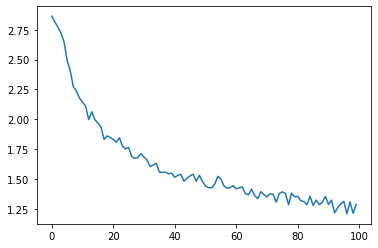

In [71]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

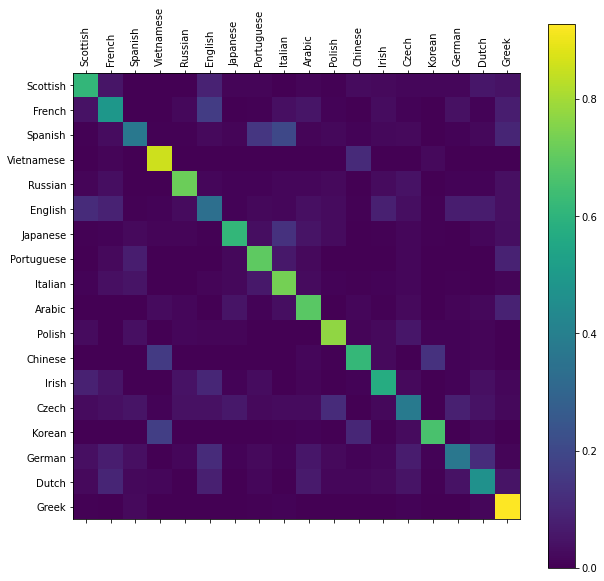

In [73]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000


# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output



# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_cats.index(category)
    confusion[category_i][guess_i] += 1


# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()



# Set up plot
figsize = (10, 10)
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_cats, rotation=90)
ax.set_yticklabels([''] + all_cats)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [74]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_cats[category_index]))
            predictions.append([value, all_cats[category_index]])

In [76]:
predict('Aggelen')
predict('Accardo')
predict('Ferreiro')
predict('Abukara')


> Aggelen
(-1.05) Dutch
(-1.51) English
(-1.97) Irish

> Accardo
(-0.23) Italian
(-2.22) Spanish
(-2.57) Portuguese

> Ferreiro
(-0.15) Portuguese
(-2.87) Italian
(-3.12) Spanish

> Abukara
(-1.31) Spanish
(-1.69) Japanese
(-1.76) Dutch
